## Imports

In [1]:
import pandas as pd
import sys
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Reading and Cleaning Data
In the following secution...

In [15]:
class Data:
    """ This class handles everthing related to the data analysis. 
    
    The Data object holds the train- and testdatasets as well as the column names and the names of the 
    categorical features which are required for categorical classification.\n
    It contains the following object variables:
    names: list of strings containing the labels of the columns
    learndata: pd array of a converted csv file. This data is used for the training.
    testdata: pd array of a converted csv file. This data is used for the testing.
    categorical_features: list of strings containing the labels of all categorical features.
    target: string of the label of the row that contains the target variables of the pd arrays learndata and testdata.
    x_train: pd array that contains the training features.
    y_train: pd array that contains the training targets.
    x_test: pd array that contains the test features.
    y_test: pd array that contains the test targets.


    The following Methods can be used to generate classifier objects of the Data object,
    which can get used for predicting scores and plotting performances and so on.
    They always use the Data object which contains the data they get trained on. \n
    do_log_regr(self): returns a logistical regression classifier object of the Data.
    do_gradient_boosting_trees(self): create a gradient boosting trees classifier object of the Data.
    do_decission_tree(self): returns a decission tree classifier object of the Data.
    do_neural_network(self): returns a neural network classifier object of the Data.
    do_svm(self): returns a support vector machine classifier object of the Data.
    do_kneighbors(self): returns a k-nearest neighbor classifier object of the Data.
    do_naive_bayes(self): returns a naive bayes classifier object of the Data.
    """

    def __init__(self, files, names, categorical_features, target, sep = ","):
        """ Takes files, names and categorical_features as an array of strings as an input. 

        The files have to be entered in a list as following: 1. item is the traindata, 2. item is the testdata.
        (optionally 3. item but this is only important if you want to safe the classification report.)
        The names are used as the names of the rows in the data (last name is always the target).
        The categorical features must be defined as the names of the data which is categorical.
        target: The name of the target value (must be included in names). """
        # This data will be used to analyse the dataset (add variability maybe).
        self.names = names

        self.traindata = pd.read_csv((files[0]), names=self.names, sep=sep)
        self.testdata = pd.read_csv((files[1]), names=self.names, sep=sep)

        self.categorical_features = categorical_features

        self.target = target
        
        self.setup_data()

    def setup_data(self):
        """ set up the data for classification """
        traindata = self.remove_incomplete_data(self.traindata)
        testdata = self.remove_incomplete_data(self.testdata)
        
        self.y_train = self.set_target(traindata)
        self.y_test = self.set_target(testdata)

        # set dummies of combined train and test data with removed target variable
        fulldata = self.get_dummies(traindata.append(testdata, ignore_index=True).drop(self.target, axis=1).drop("fnlwgt", axis=1), self.categorical_features)
        self.x_train = fulldata[0:len(traindata)]
        self.x_test = fulldata[len(traindata):len(fulldata)]

    def get_categorical_features(self):
        """ Return the categorical features of the data as array. """
        return self.categorical_features

    def remove_incomplete_data(self, data):
        """ Remove every row of the data that contains atleast 1 "?". """
        return data.replace("?", np.nan).dropna(0, "any")

    def get_dummies(self, data, categorical_features):
        """ Get the dummies of the categorical features for the given data. """
        for feature in self.categorical_features:
            # create dummyvariable with pd.get_dummies and drop all categorical variables with dataframe.drop
            data = data.join(pd.get_dummies(data[feature], prefix=feature, drop_first=True)).drop(feature, axis=1)
        return data

    def set_target(self, data):
        """ Set the target values of the target variables (0,1 for either case). """
        for i in range(len(data[self.target].unique())):
            data[self.target] = np.where(data[self.target] == data[self.target].unique()[i], i, data[self.target])
        return data[self.target].astype("int")

    def do_log_regr(self):
        """ Return a logistic regression classifier object. """
        clf = LogisticRegression(solver="lbfgs")
        return clf.fit(self.x_train, self.y_train)
    
    def do_gradient_boosting_trees(self):
        """ Return a gradient boosting trees classifier object. """
        clf = GradientBoostingClassifier(n_estimators=4000, learning_rate=0.04, max_depth=2, random_state=0)
        return clf.fit(self.x_train, self.y_train)

    def do_decission_tree(self):
        """ Return a decission tree classifier object. """
        clf = tree.DecisionTreeClassifier()
        return clf.fit(self.x_train, self.y_train)
    
    def do_neural_network(self, hidden_layer_size=(100,), max_iter=200):
        """ Return a nn classifier object. 
        
        Optional arguments:\n 
        hidden_layer_size: Tuple of ints that defines the size and the amount of hidden layers. (default (100,))) 
        max_iter: Int that defines the maximum amount of training iterations. (default 200) """
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer_size,\
             max_iter=max_iter, tol=0.000001, n_iter_no_change=250, early_stopping=False, verbose=False,
              learning_rate="adaptive", validation_fraction=0)
        return clf.fit(self.x_train, self.y_train)

    def do_svm(self):
        """  Return an svm classifier object.  """        
        clf = SVC(gamma="auto")
        return clf.fit(self.x_train, self.y_train)

    def do_kneighbors(self):
        """ Return a k-nn object. """
        clf = KNeighborsClassifier(n_neighbors=5)
        return clf.fit(self.x_train, self.y_train)

    def do_naive_bayes(self):
        """ Return a native bayes classifier object. """
        clf = GaussianNB()
        return clf.fit(self.x_train, self.y_train)

    def do_gaussian_process_regressor(self):
        """ Return a gaussian process regressor classifier object. """
        clf = GaussianProcessRegressor()
        return clf.fit(self.x_train, self.y_train)
    
    def do_dummy_classifier(self):
        """ Return a dummy classifier object. """
        clf = DummyClassifier()
        return clf.fit(self.x_train, self.y_train)

    def get_classification_report(self, clf, x, y, label=""):
        """ Return a ClassificationReport object. 

        Arguments:\n
        clf: The classifier to be reported.\n
        x: The feature values.\n
        y: The target values to validate the predictions. \n
        label: (optionally) sets a label."""
        roc_auc = roc_auc_score(y, clf.predict_proba(x)[:,1])
        fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(x)[:,1])
        return ClassificationReport(metrics.confusion_matrix(y, clf.predict(x)), 
        metrics.classification_report(y, clf.predict(x)), roc_auc, fpr, tpr, thresholds , label)

## Generating the Output plots
...

In [3]:
class Plotting:
    """ Contains the stuff for plotting. """
    def plot_roc_curve(self, classification_reports):
        """ Plot the as an array given classification reports roc curves. """
        #create the plots
        if len(classification_reports) > 2:
            fig, ax = plt.subplots(ncols=2, nrows=int(len(classification_reports)/2) + len(classification_reports) % 2)
            #removes last ax if uneven:
            if (len(classification_reports) % 2) == 1:
                fig.delaxes(ax[int(len(ax) - 1), 1])
            for i in range(len(classification_reports)):
                ax[int(i/2), i%2].plot(classification_reports[i].fpr, classification_reports[i].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[i].label, classification_reports[i].roc_auc),\
                        color=Plotting.color2)
                # plots the f(x) = x line:
                ax[int(i/2), i%2].plot([0, 1], [0, 1], color=Plotting.color1)
                ax[int(i/2), i%2].set_xlim([0.0, 1.0])
                ax[int(i/2), i%2].set_ylim([0.0, 1.0])
                ax[int(i/2), i%2].set_title(classification_reports[i].label)
                ax[int(i/2), i%2].set_ylabel('True Positive Rate')
                ax[int(i/2), i%2].set_xlabel('False Positive Rate')
                ax[int(i/2), i%2].legend(loc="lower right")

        elif len(classification_reports) == 2:
            fig, ax = plt.subplots(ncols=2, nrows=1)
            for i in range(len(classification_reports)):
                ax[i].plot(classification_reports[i].fpr, classification_reports[i].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[i].label, classification_reports[i].roc_auc),\
                        color=Plotting.color2)
                # plots the f(x) = x line:
                ax[i].plot([0, 1], [0, 1], color=Plotting.color1)
                ax[i].set_xlim([0.0, 1.0])
                ax[i].set_ylim([0.0, 1.0])
                ax[i].set_title(classification_reports[i].label)
                ax[i].set_ylabel('True Positive Rate')
                ax[i].set_xlabel('False Positive Rate')
                ax[i].legend(loc="lower right")

        elif len(classification_reports) == 1:
            fig, ax = plt.subplots(ncols=1, nrows=1)
            ax.plot(classification_reports[0].fpr, classification_reports[0].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[0].label, classification_reports[0].roc_auc),\
                        color=Plotting.color2)
                # plots the f(x) = x line:
            ax.plot([0, 1], [0, 1], color=Plotting.color1)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_title(classification_reports[0].label)
            ax.set_ylabel('True Positive Rate')
            ax.set_xlabel('False Positive Rate')
            ax.legend(loc="lower right")
        
        plt.suptitle('Receiver operating characteristic')
        plt.tight_layout()
        plt.show()
        return

## Classification Report
This class handles everything that is related to displaying the performance of a classificator.

In [4]:
class ClassificationReport:
    """ Object to Print the classification report data. """
    def __init__(self, matrix, report, roc_auc, fpr, tpr, thresholds, label):
        """ Takes sklearn matrix and report as arguments. """
        self.matrix = matrix
        self.report = report
        self.roc_auc = roc_auc
        self.fpr = fpr
        self.tpr = tpr
        self.thresholds = thresholds
        if label == "":
            self.label = None
        else:
            self.label = label
        
    def __repr__(self):
        """ Represent object as string containing its information. """
        x = "\tt\t" + "f\n" + "n\t" + str(self.matrix[0][0]) + "\t" + str(self.matrix[0][1]) + \
            "\n" + "p\t" + str(self.matrix[1][1]) + "\t" + str(self.matrix[1][0])
        x += ("\n" + self.report)
        return x

    def write_to_file(self, file, additional = []):
        """ Write a ClassificationReport object to a file. 

        Arguments:
        file: The file to write to.
        additional: (optional) to display additional information at the beginning. """
        if additional == []:
            with open(file, "a") as file:
                file.write(self.__repr__())
        else:
            with open(file, "a") as file:
                file.write(str(additional) + "\n" + self.__repr__())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   

        marital-status        occupation    relationship    race    sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         Husband   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1             0             0              13   United-States  
   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      0                    0                       0   
1          

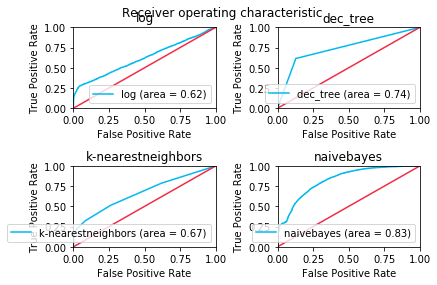

log 
 0.7978011178674529
decision tree
 0.8109452736318408
knn
 0.7767950371598796
naive bayes
 0.7957127940544193


In [16]:
def main():
    files = ["./repo/data_files/adult.data.txt", \
        "./repo/data_files/adult.test.txt"]
    names = ["age","workclass","fnlwgt","education","education-num",
                "marital-status","occupation","relationship","race","sex",
                "capital-gain","capital-loss","hours-per-week","native-country",
                "income"]
    categorical_features = ["workclass","education","race","sex","marital-status","occupation","relationship",
            "native-country"]
    data = Data(files, names, categorical_features, "income")

    log_time = time.time()
    log = data.do_log_regr()
    log_time = time.time() - log_time
    dec_tree_time = time.time()
    dec_tree = data.do_decission_tree()
    dec_tree_time = time.time() - dec_tree_time
    # svm = data.do_svm()
    gbt_time = time.time()
    gbt = data.do_gradient_boosting_trees()
    gbt_time = time.time() - gbt_time
    knn_time = time.time()
    knn = data.do_kneighbors()
    knn_time = time.time() - knn_time
    naive_bayes_time = time.time()
    naive_bayes = data.do_naive_bayes()
    naive_bayes_time = time.time() - naive_bayes_time
    nn_time = time.time()
    nn = data.do_neural_network((20,20,20,20,20,20,20,20,20,),5000)
    nn_time = time.time() - nn_time
    # dummy = data.do_dummy_classifier()
    classification_reports = []
    classification_reports.append(data.get_classification_report(log, data.x_test, data.y_test, label = "Logistische Regression"))    
    classification_reports.append(data.get_classification_report(dec_tree, data.x_test, data.y_test, label="Decision Tree"))
    # classification_reports.append(data.get_classification_report(svm, data.x_test, data.y_test, label = "svm"))
    classification_reports.append(data.get_classification_report(gbt, data.x_test, data.y_test, label = "Gradient Boosting Trees"))    
    classification_reports.append(data.get_classification_report(knn, data.x_test, data.y_test, label="k-nearest Neighbors"))    
    classification_reports.append(data.get_classification_report(naive_bayes, data.x_test, data.y_test, label="Naive Bayes"))
    classification_reports.append(data.get_classification_report(nn, data.x_test, data.y_test, label = "Neuronales Netz"))
    # classification_reports.append(data.get_classification_report(dummy, data.x_test, data.y_test, label = "dummy"))
    Plotting.plot_roc_curve(Plotting, classification_reports)
    print("log \n", log.score(data.x_test, data.y_test), log_time, "\n", classification_reports[0])
    print("decision tree\n", dec_tree.score(data.x_test, data.y_test), dec_tree_time, "\n", classification_reports[1])
    print("gradient boosting\n" , gbt.score(data.x_test, data.y_test), gbt_time, "\n", classification_reports[2])
    print("knn\n", knn.score(data.x_test, data.y_test), knn_time, "\n", classification_reports[3])
    print("naive bayes\n", naive_bayes.score(data.x_test, data.y_test), naive_bayes_time, "\n", classification_reports[4])
    print("nn\n", nn.score(data.x_test, data.y_test), nn_time, "\n", classification_reports[5])

In [ ]:
main()